# 0.1.2 Combigen Stacks

When putting the model together, I realized the O'Reily task requires that groups of four inputs be sent into the models. So this notebook will go theough the process of modifying and ensuring the task does this properly.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn

Mon Feb 18 2019 22:23:28 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 63aa85b0c2db9af7f58e4a10b50490d68e54af03
Git branch : resnet


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging
from pprint import pprint

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Progress bar
from tqdm import tqdm

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cbg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cbhm
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging, make_input_3d, flatten

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [7]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## Stacked Labels

For more detail on the task, check out nb-0.1 and nb-0.1.1. For now, let's instantiate local versions of the relevant combigen functions so we can start modifying them.

First let's start the label generation function, `generate_labels`.

In [8]:
def generate_labels(n_samples=1, size=5, dims=2):
    """..."""
    # Generate baseline labels
    raw_labels = np.random.choice(2, (n_samples, size, dims), replace=True)
    # Random selection of indices to zero out
    arg_zero = np.random.choice(size, (n_samples*dims), replace=True)
    # Alternating indices to loop through the dims of the labels
    dim_indices = np.tile(range(dims), n_samples)
    # Repeating indices to loop through the samples
    sample_indices = np.repeat(range(n_samples), dims)
    
    # Zero out a random selection of indices
    raw_labels[sample_indices, arg_zero, dim_indices] = 0
    return raw_labels

And let's just see what a resulting label look like.

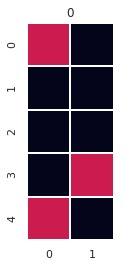

In [9]:
example_y = generate_labels()
cbhm.heatmap(example_y)
plt.show()

So let's make a better version that will include stacks, and see what it outputs.

In [10]:
def generate_labels_stacked(n_samples=1, stack=4, size=5, dims=2):
    """..."""
    # Generate baseline labels
    raw_labels = np.random.choice(2, (n_samples, stack, size, dims), replace=True)
    # Random selection of indices to zero out
    arg_zero = np.random.choice(size, (n_samples*dims*stack), replace=True)
    # Alternating indices to loop through the dims of the labels
    dim_indices = np.tile(range(dims), stack*n_samples)
    # Repeating indices to loop through the samples
    sample_indices = np.repeat(range(n_samples), dims*stack)
    # Stack indices
    stack_indices = np.repeat(np.tile(range(stack), n_samples), dims)
    
    # Zero out a random selection of indices
    raw_labels[sample_indices, stack_indices, arg_zero, dim_indices] = 0
    return raw_labels

stacked_y = generate_labels_stacked()
print(stacked_y.shape)
print(stacked_y)

(1, 4, 5, 2)
[[[[0 1]
   [0 0]
   [0 0]
   [0 0]
   [1 1]]

  [[0 0]
   [1 0]
   [0 0]
   [0 0]
   [1 0]]

  [[0 0]
   [0 0]
   [1 0]
   [1 0]
   [0 0]]

  [[1 0]
   [0 0]
   [0 0]
   [1 0]
   [1 0]]]]


Looks good so far, lets run a couple tests to ensure the zeroing is working properly. First check that it trivially returns arrays of the requested shape.

In [11]:
# A list of shapes that will be used to test the labels
test_shapes_01 = [[1, 4, 5, 2], [10, 4, 5, 2], [1,1,1,1], [10,10,10,10]]

# Test the resulting shape
for shape in tqdm(test_shapes_01):
    assert np.array_equal(generate_labels_stacked(*shape).shape, shape)
logger.info('Passed!')

100%|██████████| 4/4 [00:00<00:00, 1587.40it/s]
2019-02-18 22:23:30 apra-xps13 leabratf[7129] INFO Passed!


Next, let's make sure the zeroing fix is still working for all stacks. Borrowing and tweaking the function in nb-0.1.1:

In [12]:
def test_all_label_counts(func=generate_labels_stacked, n_labels=1000000, *args, **kwargs):
    """Genrates `n_labels` labels and checks their sums."""
    # Generate a large number of y values to test
    large_test_Y = func(n_labels, *args, **kwargs)
    
    n, stacks, size, dims = large_test_Y.shape
    assert n == n_labels
    
    # Sum over the long dimension of each sample to see how many of them are set to
    # the on state. If they are all on, then it will sum to the length of the dim.
    label_sums = np.sum(large_test_Y, axis=2)
    
    expected_values_in_sum = np.isin(range(size + 1), label_sums)
    assert len(expected_values_in_sum) == len(range(size + 1))
    
    # Get unique values in the sum and their counts and put them in a dict
    count_dict = {val:count for val, count in zip(
        *np.unique(label_sums, return_counts=True))}
    # Sanity check
    assert sum(count_dict.values()) == n_labels * dims * stacks
    
    # Perform the actual check
    assert all(expected_values_in_sum == size*[True] + [False])    

# A list of shapes that will be used to test the labels
test_shapes_02 = [[4, 5, 2], [1, 1, 1], [5, 5, 5]]

for shape in tqdm(test_shapes_02):
    test_all_label_counts(generate_labels_stacked, 1000000, *shape)
logger.info('Passed!')

100%|██████████| 3/3 [00:05<00:00,  2.13s/it]
2019-02-18 22:23:36 apra-xps13 leabratf[7129] INFO Passed!


## Heatmap for Stacked Labels

Now let's try to get the heatmap to work with the new shape of the labels. First let's show the old implementation.

In [13]:
# General warning, this will overwrite the originally defined heatmap
@make_input_3d
def heatmap(data, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            samples_per_row=10, gridspec_kw=None, sharey=True, sharex=True,
            titles=None, *args, **kwargs):
    """See cbhm.heatmap for the full docstring"""
    # Place them all in a subplot
    n_samples = len(data)
    ver_size = n_samples // samples_per_row
    ver_size = ver_size + 1 if n_samples % samples_per_row else ver_size
    
    hor_size = (samples_per_row 
                if (ver_size > 1 or n_samples == samples_per_row) 
                else n_samples % samples_per_row)
    # Create the subplot axes
    _, axn = plt.subplots(ver_size, hor_size, sharey=sharey, sharex=sharex,
                          squeeze=False, gridspec_kw=gridspec_kw)

    # Create a titles generator
    if titles is not None:
        titles = iter(titles)
    else:
        titles = count(start=0, step=1)
    # Collect the returned heatmap parameters
    heatmaps = []

    # Loop through and generate the plots
    gen_data = iter(data)
    for i in range(ver_size):
        try:
            for j in range(hor_size):
                array = next(gen_data)
                shape = array.shape
                if len(shape) == 3 and shape[0] == 1:
                    array = array.reshape(shape[1:])
                heatmaps.append(sns.heatmap(
                    array, vmin=vmin, vmax=vmax, cbar=cbar,
                    linewidths=linewidths, square=square, ax=axn[i,j], *args,
                    **kwargs))
                axn[i,j].set_title(next(titles))
        except StopIteration:
            break
    return heatmaps

And now let's redefine it with some changes.

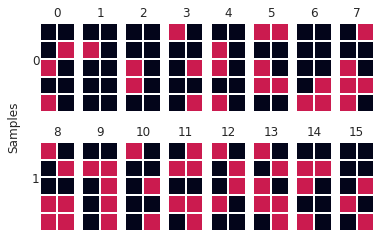

In [123]:
from itertools import count

def heatmap_stacked(data, data2=None, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            samples_per_row=10, gridspec_kw=None, sharey=True, sharex=True,
            titles=None, squeeze=False, y_label='Samples', x_label=None, *args, **kwargs):
    """See cbhm.heatmap for the full docstring"""
    n_samples, stack, size, dims = data.shape
    # Check if another dataset was passed
    hor = stack if data2 is None else stack + data2.shape[1]
    # Place everything in subplots
    fig, axn = plt.subplots(n_samples, hor, sharey=sharey, sharex=sharex,
                            squeeze=squeeze, gridspec_kw=gridspec_kw)
    if x_label is not None:
        fig.suptitle(x_label)

    # Create a titles generator
    if titles is not None:
        titles = iter(titles)
    else:
        titles = count(start=0, step=1)
    # Collect the returned heatmap parameters
    heatmaps = []

    # Loop through and generate the plots
    gen_data = iter(data) if data2 is None else zip(data, data2)
    
    for i, sample in enumerate(gen_data):
        if data2 is None:
            stacks = [stack for stack in sample]
        else:
            stacks = [stack for data in sample for stack in data]
            
        for j, stack in enumerate(stacks):
            if len(shape) == 3 and shape[0] == 1:
                stack = stack.reshape(shape[1:])
        
            heatmaps.append(sns.heatmap(
                stack, vmin=vmin, vmax=vmax, cbar=cbar, xticklabels=False,
                yticklabels=False,
                linewidths=linewidths, square=square, ax=axn[i,j], *args,
                **kwargs))
            axn[i,j].set_title(next(titles))
            
            if j is 0:
                axn[i,j].set_ylabel(i, rotation=0)
    
    # Common Labels
    if y_label is not None:
        fig.text(0.05, 0.5, y_label, va='center', rotation='vertical')
    
    return heatmaps

N = 2
heatmap_stacked(generate_labels_stacked(N),generate_labels_stacked(N))
plt.show()

## Stacked Inverse Transform 

And now let's rework `inverse_transform`. Below is the old implementation.

In [49]:
def inverse_transform_single_sample(y):
    """..."""
    # Grab the length of y
    size, _ = y.shape
    # Create a horizontal array and a vertical array according to y
    horizontal, vertical = np.tile(y, size).reshape(size, size, 2).T
    return (horizontal.T + vertical).astype(bool).astype(np.float32)

@make_input_3d
def inverse_transform(Y, *args, **kwargs):
    """..."""
    length, size, dims = Y.shape
    return np.concatenate([inverse_transform_single_sample(y) for y in Y],
                          axis=0).reshape(length, *([size]*dims))

And now let's make it a stacked implementation.

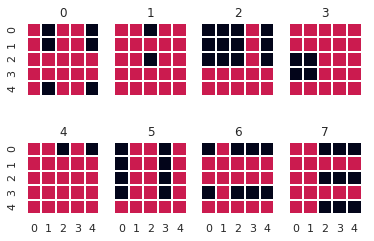

In [45]:
def inverse_transform_stacked(Y, *args, **kwargs):
    """..."""
    n_samples, stack, size, dims = Y.shape
    return np.concatenate([inverse_transform_single_sample_stacked(face) 
                           for y in Y for face in y], axis=0).reshape(
        n_samples, stack, *([size]*dims))

heatmap_stacked(inverse_transform_stacked(generate_labels_stacked(2)))
plt.show()

And now let's test to make sure the inverse transform is still correct.

In [52]:
test_shapes_03 = [[1, 4, 5, 2], [10, 4, 5, 2], [10,10,10,2]]

for shape in tqdm(test_shapes_03):
    example_y = generate_labels_stacked(*shape)
    n_samples, stack, size, dim = example_y.shape
    expected_X = np.concatenate(
        np.array([inverse_transform(y).reshape(1, stack, size, size)
                  for y in example_y]), axis=0)
    generated_X = inverse_transform_stacked(example_y)
    assert np.array_equal(expected_X, generated_X)    
logger.info('Passed!')

100%|██████████| 3/3 [00:00<00:00, 386.09it/s]
2019-02-18 22:54:09 apra-xps13 leabratf[7129] INFO Passed!


## Stacked Combigen Visualization

The last function that needs to be changed is `visualize_combigen`, so just like before let's show the original implmentation.

In [53]:
def visualize_combigen(n_pairs=1, *args, **kwargs):
    """..."""
    heatmaps = []
    # Visulize a few combinations of x and y
    for _ in range(n_pairs):
        # Generate a signle y
        example_y = cg.generate_labels(n_samples=1, *args, **kwargs)
        # Generate a single x from the y
        example_x = cg.inverse_transform(example_y)
        heatmaps.append(heatmap([example_y, example_x[0]],
                                gridspec_kw={'width_ratios': [2, 5]},
                                sharex=False,
                                titles=['y', 'X']))
    return heatmaps

And then the changed version:

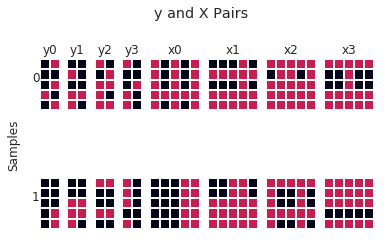

In [128]:
def visualize_combigen_stacked(n_pairs=2, *args, **kwargs):
    """..."""
    heatmaps = []
    # Generate a signle y
    example_y = generate_labels_stacked(n_samples=n_pairs, *args, **kwargs)
    # Generate a single x from the y
    example_x = inverse_transform_stacked(example_y)
    
    _, stack, size, dim = example_y.shape
    titles = [a+str(i) for a in ['y','x'] for i in range(4)] + ['']*(n_pairs-1)*stack*2
    gridspec_kw={'width_ratios': [dim]*stack + [size]*stack}
    
    heatmaps.append(heatmap_stacked(example_y, example_x,
                                    gridspec_kw=gridspec_kw,
                                    sharex=False,
                                    titles=titles,
                                    x_label='y and X Pairs'))
    return heatmaps

visualize_combigen_stacked()
plt.show()

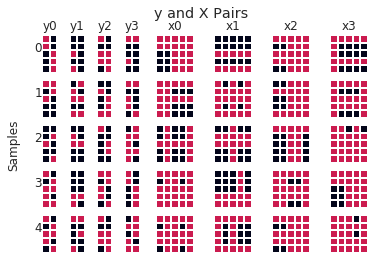

In [129]:
# And once more with more pairs
visualize_combigen_stacked(5)
plt.show()

## Performance

Last thing to check for is the performance change with the added implementation. Let's compare the new implementation compared to the old one when required to generate four times as much data. 

In [133]:
def generate_unstacked_data(n_samples=1000):
    Y = generate_labels(n_samples*4)
    x = inverse_transform(Y)
    return x, Y

def generate_stacked_data(n_samples=1000):
    Y = generate_labels_stacked(n_samples)
    x = inverse_transform_stacked(Y)
    return x, Y

# Now show the timing
print('Timing of old implementation:')
%timeit generate_unstacked_data()
print('Timing of stacked implementation:')
%timeit generate_stacked_data()

Timing of old implementation:
47.6 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Timing of stacked implementation:
47.6 ms ± 628 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


More or less identical.